## Latenz-Analyse 

### Vier Dimensionen 

#### 1. Dimension: Stage 
S0, S1, S2, S3 …

#### 2. Dimension: Mode
concurrent / independent

#### 2. Dimension: Platform
ce / cr

#### 2. Dimension: Batching
batch / nobatch


### Cloud Run-CSV ist stufenunabhangig und muss aggregiert werden

--> pro Mode muss eine Cloud run Referenz Linie abgebildet werden

#### 1. CR-Phasenlatenzen Sum(S0(cr)+S1(cr)+S2(cr)+S3(cr)+S4(cr)) batch / concurrent 
S0 : for cr ist summe aus allen latencies_cr_batch deren eltern ordner und wieder eltern ordenr also sozusagen großeltenr ordner S0_concurrent enthält ... dh wir suchen aus S0_concurrent nach allen kindkind elementen die latencies_cr_batch in namen haben udn das selbe machen wir für die ganezn anderen stages 

hier haben wir 24 werte 
#### 2. CR-Phasenlatenzen Sum(S0(cr)+S1(cr)+S2(cr)+S3(cr)+S4(cr)) batch / independent

#### 3. CR-Phasenlatenzen Sum(S0(cr)+S1(cr)+S2(cr)+S3(cr)+S4(cr)) nobatch / concurrent 

#### 4. CR-Phasenlatenzen Sum(S0(cr)+S1(cr)+S2(cr)+S3(cr)+S4(cr)) nobatch / independent




In [117]:
import json
import re
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from typing import Iterable
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display


In [118]:

TESTRESULTS_ROOT = Path("/Users/susannahufnagl/Desktop/UNI_Bachelor/TU Berlin/lebach/ba/Testresults") # so lange ich aus lokal arbeite
METRIC_COL = ["client_total_ms", "Server-Latency (server_latency_ms)"]
METRIC_CLIENT = "client_total_ms"
METRIC_SERVER = "server_latency_ms"
METRICS = [METRIC_CLIENT, METRIC_SERVER]


STAGES = ["S0", "S1", "S2", "S3", "S4"]
MODES = ["concurrent", "independent"]
BATCHINGS = ["batch", "nobatch"]



def parse_metadata(csv_path: Path):
    
    # csv_path Beispiel:
    # Testresults/S0_concurrent/2025-11-06_17-19-50_run-6136/latencies_cr_batch_*.csv
    

    #S0_concurrent
    stage_mode = csv_path.parents[1].name ## --> ein ordner über eltern ordenr 
    stage, mode = stage_mode.split("_")

    #plattform + batching aus Dateiname nehmen
    m = re.match(r"latencies_(ce|cr)_(batch|nobatch)_", csv_path.name)
    if not m:
        raise ValueError(f"Konnte Dateinamen nicht lesen: {csv_path.name}")

    platform = m.group(1)
    batching = m.group(2)

    #run-Ordner
    run_id = csv_path.parents[0].name  #z.B.2025-11-06_17-19-50_run-6136 --> evtl ohne eckige klammer part 

    return stage, mode, platform, batching, run_id


def load_latencies(root: Path = TESTRESULTS_ROOT):
    rows = []
    for csv in root.rglob("latencies_*.csv"):
        stage, mode, platform, batching, run_id = parse_metadata(csv)
        df = pd.read_csv(csv)

        df["stage"] = stage
        df["mode"] = mode
        df["platform"] = platform
        df["batching"] = batching
        df["run"] = run_id
        df["source_file"] = csv

        rows.append(df)

    return pd.concat(rows, ignore_index=True)


lat = load_latencies()
print("CSV-Daten geladen:", lat.shape)
lat.head()










CSV-Daten geladen: (92000, 13)


,ts_iso,endpoint,http_status,client_total_ms,server_latency_ms,url,cold_start,stage,mode,platform,batching,run,source_file
0,2025-11-15T12:41:37Z,cr_nobatch,200,107.857,6.896,https://cloudrun-broker-single-go-997595983891...,NaN,S3,independent,cr,nobatch,2025-11-15_12-41-35_run-6785,/Users/susannahufnagl/Desktop/UNI_Bachelor/TU ...
1,2025-11-15T12:41:37Z,cr_nobatch,200,102.444,6.927,https://cloudrun-broker-single-go-997595983891...,NaN,S3,independent,cr,nobatch,2025-11-15_12-41-35_run-6785,/Users/susannahufnagl/Desktop/UNI_Bachelor/TU ...
2,2025-11-15T12:41:37Z,cr_nobatch,200,110.376,7.383,https://cloudrun-broker-single-go-997595983891...,NaN,S3,independent,cr,nobatch,2025-11-15_12-41-35_run-6785,/Users/susannahufnagl/Desktop/UNI_Bachelor/TU ...
3,2025-11-15T12:41:38Z,cr_nobatch,200,90.419,8.128,https://cloudrun-broker-single-go-997595983891...,NaN,S3,independent,cr,nobatch,2025-11-15_12-41-35_run-6785,/Users/susannahufnagl/Desktop/UNI_Bachelor/TU ...
4,2025-11-15T12:41:38Z,cr_nobatch,200,81.711,7.768,https://cloudrun-broker-single-go-997595983891...,NaN,S3,independent,cr,nobatch,2025-11-15_12-41-35_run-6785,/Users/susannahufnagl/Desktop/UNI_Bachelor/TU ...


## Cloud Run Aggregation
--> brauch ich nicht weil stageless, stattdessen über mode und batchin kombination gruppieren


In [119]:





def compute_cr_ref(lat, metric: str):
    return (
        lat[lat["platform"] == "cr"]
        .groupby(["mode", "batching"])[metric]
        .agg(["mean", "std", "count"])
        .reset_index()
    )


cr_ref_client = compute_cr_ref(lat, METRIC_CLIENT)
cr_ref_server = compute_cr_ref(lat, METRIC_SERVER)



## Compute Engine Aggregation


In [120]:
def aggregate_ce_by_stage(lat, metric_col: str):
 
   ##ce daten raus filtern 

    ce = lat[lat["platform"] == "ce"].copy()

    #gruppieren pro run für später Tageszeiten abhängige messungen
    per_run = (
        ce.groupby(["stage", "mode", "batching", "run"])[metric_col]
        .agg(["mean", "median", "std", "count"])
        .reset_index()
        .sort_values(["stage", "run"])
    )

    #gruppierung pro stache 
    per_stage = (
        ce.groupby(["stage", "mode", "batching"])[metric_col]
        .agg(["mean", "median", "std", "count"])
        .reset_index()
        .sort_values(["mode", "batching", "stage"])
    )
    # groups = ce.groupby(["stage", "mode", "batching"])
    # list(groups.groups.keys())[:20] 
    return per_run, per_stage
ce = lat[lat["platform"] == "ce"].copy()

groups = ce.groupby(["stage", "mode", "batching"])
list(groups.groups.keys())[:20]
# Client-Latenz
ce_run_stats_client, ce_stage_stats_client = aggregate_ce_by_stage(lat, metric_col="client_total_ms")

# # Server-Latenz
ce_run_stats_server, ce_stage_stats_server = aggregate_ce_by_stage(lat, metric_col="server_latency_ms")
ce_run_stats_server




,stage,mode,batching,run,mean,median,std,count
0,S0,concurrent,batch,2025-11-06_17-19-50_run-6136,12.211052,12.0390,0.978283,500
4,S0,concurrent,nobatch,2025-11-06_17-19-50_run-6136,6.753998,6.5940,0.930774,500
8,S0,independent,batch,2025-11-06_17-25-44_run-8284,12.003884,11.7665,1.044596,500
12,S0,independent,nobatch,2025-11-06_17-25-44_run-8284,6.652556,6.4585,0.924223,500
1,S0,concurrent,batch,2025-11-14_21-17-29_run-2627,12.227654,12.0090,1.279348,500
...,...,...,...,...,...,...,...,...
90,S4,independent,nobatch,2025-11-15_14-53-15_run-7276,8.093080,7.2390,2.400309,500
79,S4,concurrent,batch,2025-11-18_07-44-29_run-9460,14.367180,13.1990,3.424202,500
83,S4,concurrent,nobatch,2025-11-18_07-44-29_run-9460,7.962768,7.2845,2.167374,500
87,S4,independent,batch,2025-11-18_07-48-45_run-0557,14.317792,13.2155,3.026191,500


In [121]:
ce_run_stats_client, ce_stage_stats_client = aggregate_ce_by_stage(lat, metric_col="client_total_ms")
ce_run_stats_client

# ce_run_stats_client--> statisik pro run
# ce_stage_stats_client --> statistik pro stage


,stage,mode,batching,run,mean,median,std,count
0,S0,concurrent,batch,2025-11-06_17-19-50_run-6136,14.100468,13.5630,2.023076,500
4,S0,concurrent,nobatch,2025-11-06_17-19-50_run-6136,9.240072,8.5865,2.107246,500
8,S0,independent,batch,2025-11-06_17-25-44_run-8284,13.830312,13.3335,1.900173,500
12,S0,independent,nobatch,2025-11-06_17-25-44_run-8284,8.501896,7.9340,1.782181,500
1,S0,concurrent,batch,2025-11-14_21-17-29_run-2627,13.378216,12.9455,1.720968,500
...,...,...,...,...,...,...,...,...
90,S4,independent,nobatch,2025-11-15_14-53-15_run-7276,16.141744,14.3810,4.753454,500
79,S4,concurrent,batch,2025-11-18_07-44-29_run-9460,22.767120,21.3945,5.158579,500
83,S4,concurrent,nobatch,2025-11-18_07-44-29_run-9460,16.411732,15.1730,4.277153,500
87,S4,independent,batch,2025-11-18_07-48-45_run-0557,22.625468,21.0020,5.237435,500


## ReferenzLinie für Cloud Run


In [122]:


def compute_cr_reference(lat, metric_col):
   

    # pro (mode, batching) der globale Durchschnitt über alle CR-Messungen
   
    cr = lat[lat["platform"] == "cr"].copy()

    agg = (
        cr.groupby(["mode", "batching"])[metric_col]
          .agg(["mean", "median", "std", "count"])
          .reset_index()
          .sort_values(["mode", "batching"])
    )

    return agg

cr_ref_server = compute_cr_reference(lat, metric_col="server_latency_ms")
cr_ref_client = compute_cr_reference(lat, metric_col="client_total_ms")





In [123]:
## tabelle fpr plots, nimmt cr_ref ergebnise und such genau den Wert den ich für die bestimmte referenzline brauche 

def get_cr_ref(cr_ref_table, mode, batching, kind="mean"):
    row = cr_ref_table[ # --> die vier kombinationen 
        (cr_ref_table["mode"] == mode) &
        (cr_ref_table["batching"] == batching)
    ]
    if row.empty:
        raise ValueError(f"fehler {mode}/{batching}")
    return float(row.iloc[0][kind])

get_cr_ref(cr_ref_server, "concurrent", "batch") # z.B



13.146478260869566

## Ce- kumulativ Latenz für Stages 

Pro Kombination benötge ich (mode,batching)



1. CE_mean_S0

2. CE_mean_S1

3. CE_mean_S2

4. CE_mean_S3

5. CE_mean_S4 (Gesamtlatenz)

--> daraus berechne ich die Phasen Anteile:

z.B anteil_Sx = CE_mean_Sx / CE_mean_S4

--> phasen Vergrößerung

z.B delta_Sx = CE_mean_Sx - CE_mean_S(x-1)

--> relative Steigerung 

delta_rel_Sx = delta_Sx / CE_mean_S4 * 100




In [124]:
import numpy as np  # falls noch nicht oben importiert

def compute_ce_phase_metrics(ce_stage_stats, stages=STAGES):
    rows = []

    for mode in MODES:
        for batching in BATCHINGS:
            subset = ce_stage_stats[
                (ce_stage_stats["mode"] == mode) &
                (ce_stage_stats["batching"] == batching) &
                (ce_stage_stats["stage"].isin(stages))
            ].copy()

            if subset.empty:
                continue

            # sortieren nach Stage-Nummer (S0..S4)
            subset["stage_num"] = subset["stage"].str.extract(r"S(\d+)").astype(int)
            subset = subset.sort_values("stage_num")

            stage_list = list(subset["stage"])
            means = list(subset["mean"])

            base = means[0]          # S0=Basisarchitektur
            ce_total = means[-1]     # S4=vollständige Architektur
            incr_total = ce_total - base  #zusätzlicher Overhead

            # Inkremente von Phase zu Phase: S0->S1, S1->S2 etc 
            increments = [0.0]
            for i in range(1, len(means)):
                increments.append(means[i] - means[i - 1])

            # Anteile jeder Stufe am zusätzlichen Overhead (S4-S0)
            if incr_total > 0:
                parts = [inc / incr_total for inc in increments]
                delta_rel = [s * 100 for s in parts]  
            else:
                parts = [np.nan] * len(increments)
                delta_rel = [np.nan] * len(increments)

            rows.append({
                "mode": mode,
                "batching": batching,
                "stages": stage_list,
                "ce_means": means,
                "ce_base": base,
                "ce_total": ce_total,
                "ce_increment_total": incr_total,
                "phase_increments": increments,          # S_i - S_{i-1}
                "phase_parts": parts,         # Anteil am Overhead
                "phase_parts_percent": delta_rel,
            })

    return rows

ce_phase_metrics_client = compute_ce_phase_metrics(ce_stage_stats_client)
ce_phase_metrics_server = compute_ce_phase_metrics(ce_stage_stats_server)



## Plots 

### 1. Boxplot pro Phase (CE vs CR.Referenz)

für jede Kombination aus (batch/nobatch x concurrent/independent)

--> Boxplots für S0-5
--> horizontale Linie für CR-Referenz, die bleibt aber konstant weil keine Phasen


### 2. Linienplot der CE-Mittelwerte pro Phase

--> CE_mean_S0 --> CE_mean_S1 --> CE_mean_S2 --> CE_mean_S3 --> CE_mean_S4
--> CR-Referenz-Linie dazu

zeigt, ob

1. CE sich der CR-Linie annähert

2. CE schneller wächst

3. welchen Effekt batching/Mode hat


### 3. Anteil aller Phasen an S4

1.  welche Phase die größte Last verursacht

2. welche Phase optimiert werden sollte

3. ob batching/concurrent überhaupt wirkt


### 4. Verteilungsdesigner Boxplots nach Plattform 

CE vs. CR (z. B. beide Boxplots nebeneinander)
-->  zeigt Varianz, Ausreißer


### 5. Heatmap: relative Phase Importance

x-Achse = stages
y-Achse = mode/batching
Zelle = % Anteil an S4



### 1. Plot: Boxplot pro Phase (CE)+ Cr Referenz Linie 

In [144]:
# def plot_boxplots_ce_per_phase_with_cr_ref(lat, mode, batching, metric_col,
#                                        whis=(0, 99), showfliers=False):
    
#     # für eine Kombination (mode,batching):
#     # Boxplots der CE-Latenzen pro Stage
#     # CR-Referenzlinie
 
#     print("Mode:", mode)
#     print("Batching:", batching)
#     print("Metric:", metric_col)
#     subset_ce = lat[ # filter der daten aus der kombination
#         (lat["platform"] == "ce") &
#         (lat["mode"] == mode) &
#         (lat["batching"] == batching) &
#         (lat["stage"].isin(STAGES))
#     ].copy()

#     if subset_ce.empty:
#         print(f"Keine CE-Daten für {mode}/{batching}")
#         return

#     #daten je Stage
#     data = []
#     stage_labels = []

#     for stage in STAGES:
#         s = subset_ce[subset_ce["stage"] == stage][metric_col]
#         if s.empty:
#             continue
#         data.append(s.values)
#         stage_labels.append(stage)

#     cr_ref = get_cr_ref(cr_refs, mode, batching)
#     plt.figure(figsize=(10, 6))
#     plt.boxplot(data, labels=stage_labels, showfliers=True)
#     plt.axhline(cr_ref, linestyle="--", label=f"CR Referenz {cr_ref:.2f} ms")

    
    
#     # plt.axhline(cr_ref, linestyle="--", label=f"CR Referenz (mean sum) {cr_ref:.2f} ms")

#     plt.title(f"Compute Engine Boxplots pro Stage mit CR-Referenz\nMode={mode}, Batching={batching}")
#     plt.xlabel("Stage")
#     plt.ylabel(f"Latenz ({metric_col})")
#     plt.legend()
#     plt.grid(axis="y", alpha=0.3)
#     plt.show()

# holt alle ce Latenzen und baut für jede stage boxlot, und nimmt gleiche cloud run kombi Referenz 

def plot_boxplots_ce_per_phase_with_cr_ref(lat, mode, batching, metric_col, metric_label,
                                           whis=(0, 99), showfliers=False):
    print("Mode:", mode)
    print("Batching:", batching)
    print("Metric:", metric_col)

    subset = lat[
        (lat["mode"] == mode) &
        (lat["batching"] == batching) &
        (lat["stage"].isin(STAGES))
    ].copy()
    ce = subset[subset["platform"] == "ce"]
    cr = subset[subset["platform"] == "cr"]

    if ce.empty or cr.empty:
        print(f"No CE- or CR data for {mode}/{batching}")
        return

    plt.figure(figsize=(12, 6))
    pos = np.arange(len(STAGES)) * 2  # Abstand zwischen Stages
    ce_color, cr_color = "#4c72b0", "#dd8452"

    for i, stage in enumerate(STAGES):
        ce_vals = ce[ce["stage"] == stage][metric_col]
        cr_vals = cr[metric_col]  # gleiche CR-Verteilung für alle Stages zum Vergleich
        if ce_vals.empty or cr_vals.empty:
            continue

        plt.boxplot(
            ce_vals,
            positions=[pos[i] - 0.35],
            widths=0.6,
            whis=whis,
            showfliers=showfliers,
            patch_artist=True,
            boxprops={"facecolor": ce_color, "alpha": 0.7},
            medianprops={"color": "black"},
        )
        plt.boxplot(
            cr_vals,
            positions=[pos[i] + 0.35],
            widths=0.6,
            whis=whis,
            showfliers=showfliers,
            patch_artist=True,
            boxprops={"facecolor": cr_color, "alpha": 0.7},
            medianprops={"color": "black"},
        )
        ce_med = np.median(ce_vals)
        cr_med=np.median(cr_vals)
        plt.text(pos[i] - 0.35, ce_med, f"{ce_med:.2f}", ha="center", va="bottom", fontsize=8, color="black")
        plt.text(pos[i] + 0.35, cr_med, f"{cr_med:.2f}", ha="center", va="bottom", fontsize=8, color="black")

    plt.xticks(pos, STAGES)
    plt.title(f"Compute Engine vs. Cloud Run per stage\nMode={mode}, Batching={batching}")
    plt.xlabel("stage")
    plt.ylabel(f"latency ({metric_col})")
    plt.grid(axis="y", alpha=0.3)

    legend_handles = [
        mpatches.Patch(color=ce_color, label="CE"),
        mpatches.Patch(color=cr_color, label="Cloud Run"),
    ]
    plt.legend(handles=legend_handles)
    plt.tight_layout()
    plt.show()






Mode: concurrent
Batching: nobatch
Metric: server_latency_ms


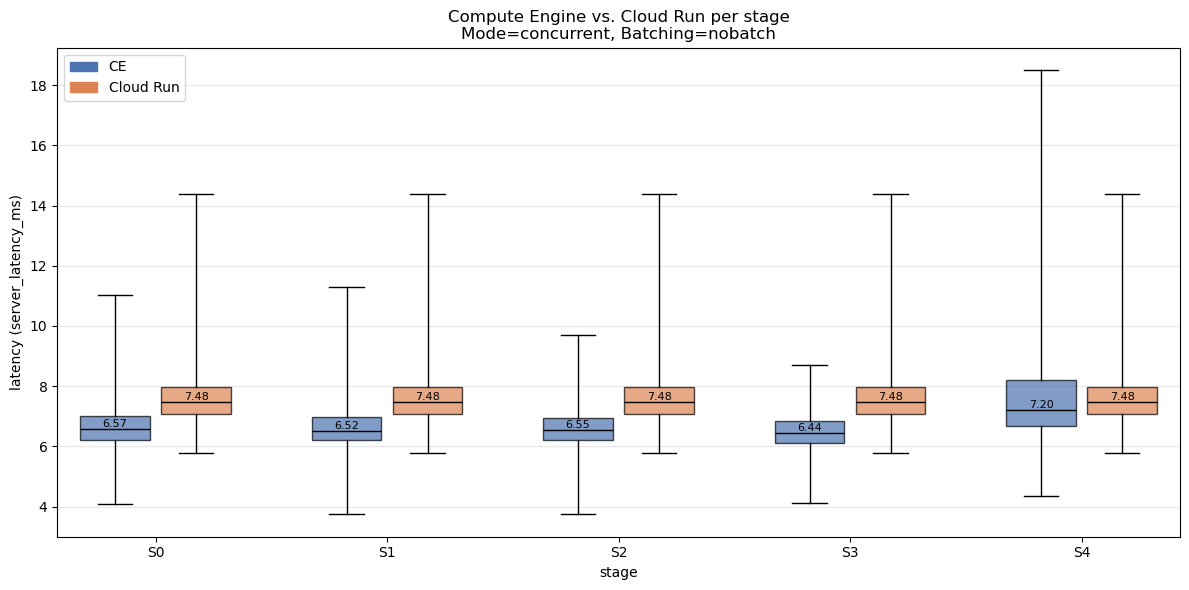

Mode: concurrent
Batching: batch
Metric: server_latency_ms


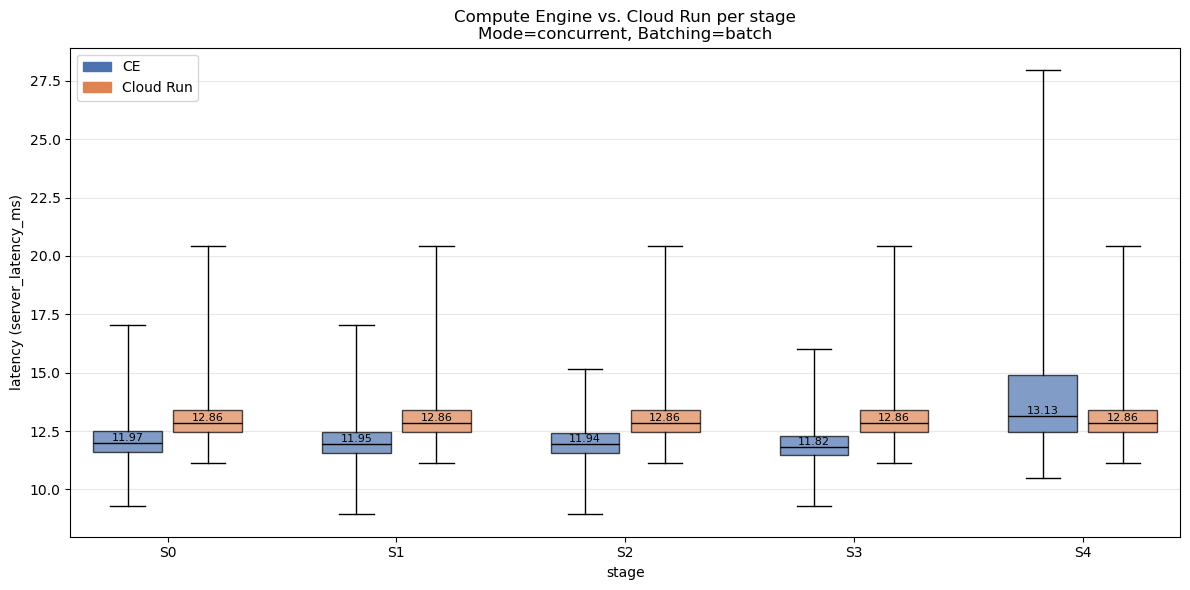

Mode: independent
Batching: nobatch
Metric: server_latency_ms


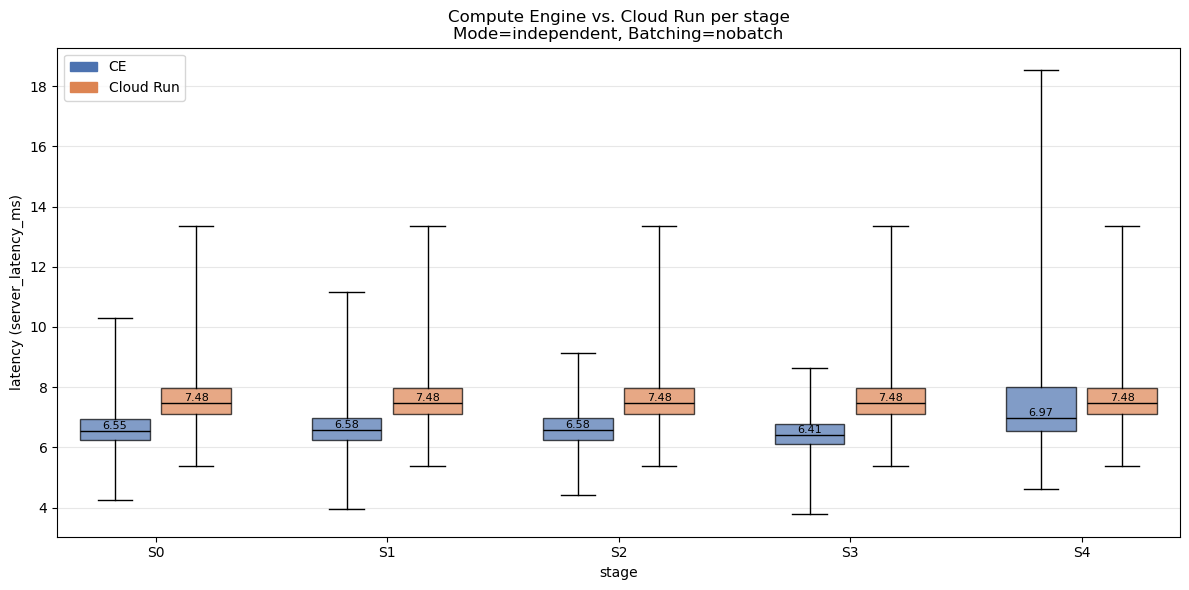

Mode: independent
Batching: batch
Metric: server_latency_ms


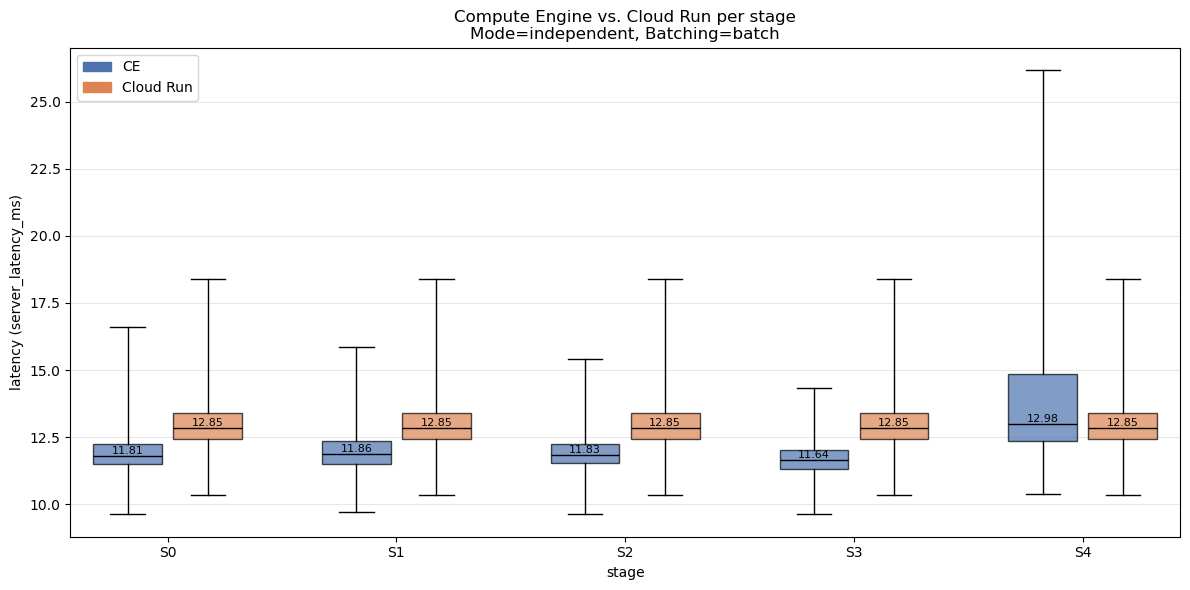

Mode: independent
Batching: batch
Metric: client_total_ms


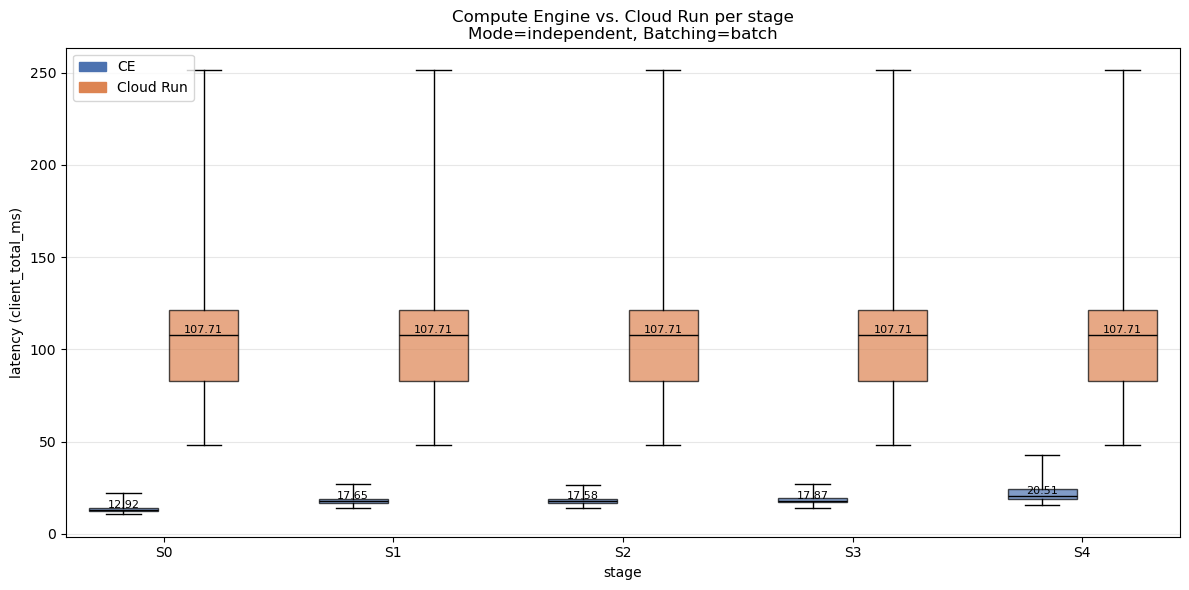

Mode: independent
Batching: nobatch
Metric: client_total_ms


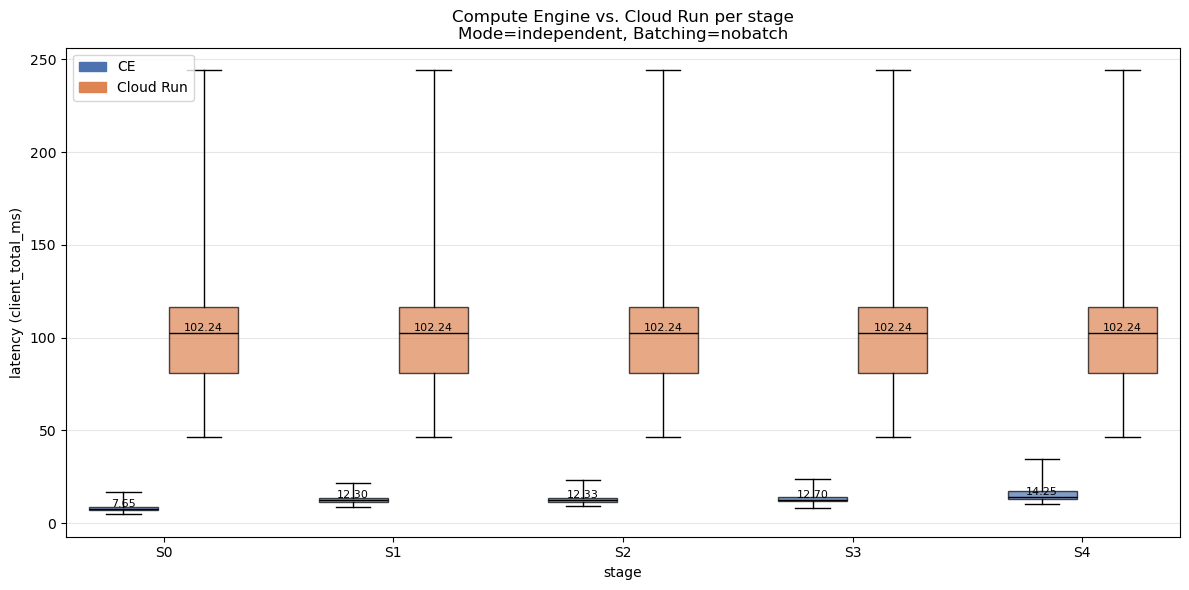

Mode: concurrent
Batching: batch
Metric: client_total_ms


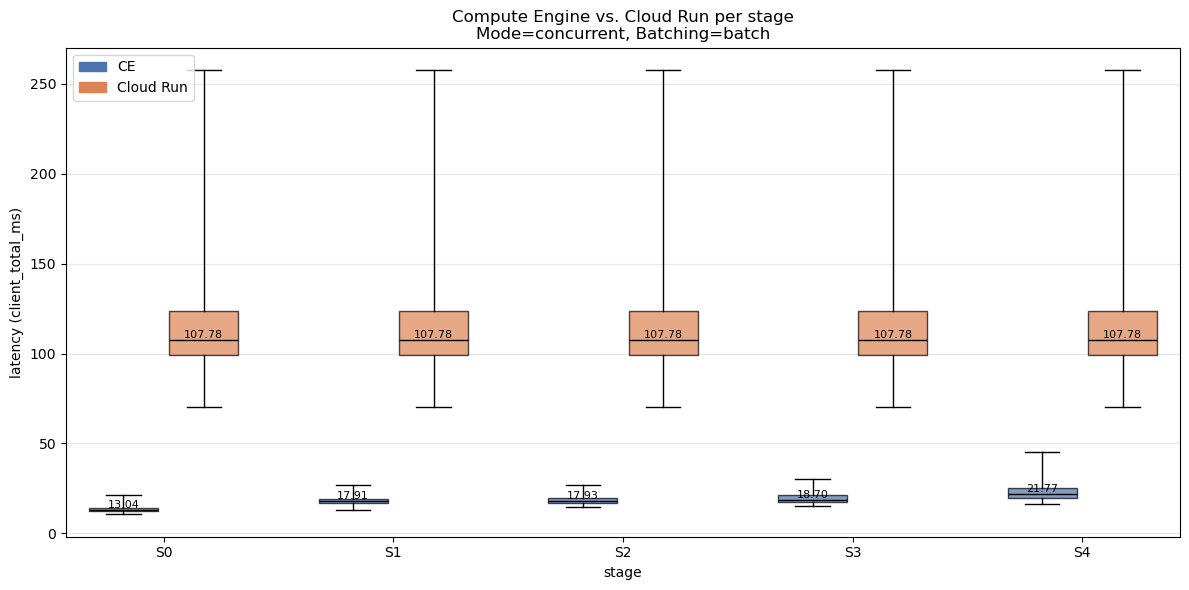

Mode: concurrent
Batching: nobatch
Metric: client_total_ms


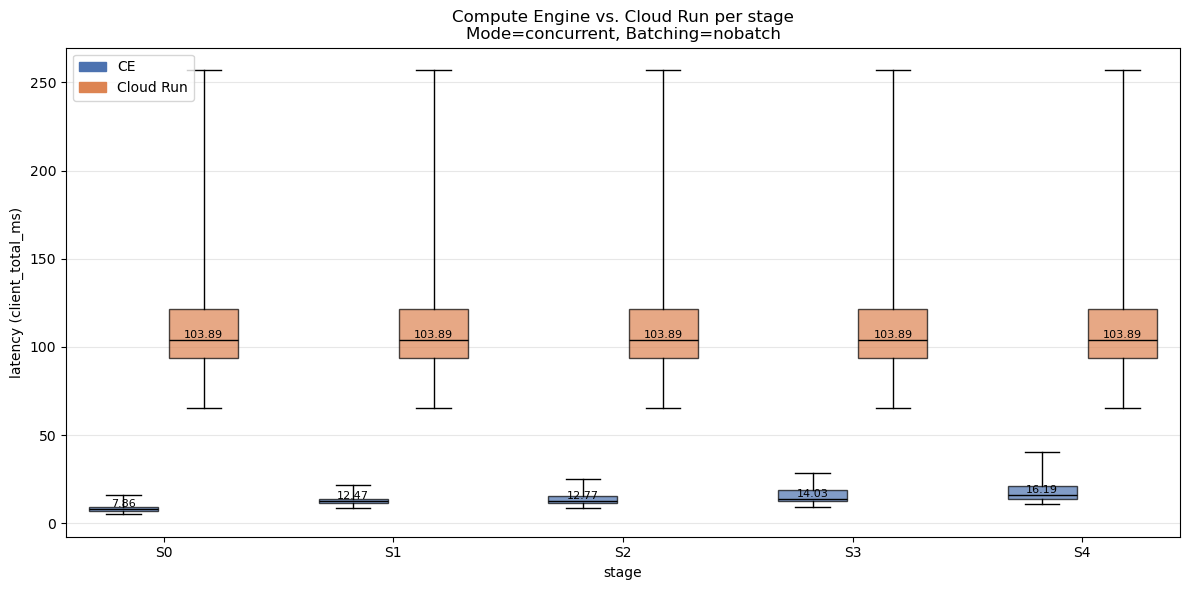

In [145]:
plot_boxplots_ce_per_phase_with_cr_ref(
    lat, mode="concurrent", batching="nobatch",
    metric_col="server_latency_ms",
    metric_label="Server-Latency (server_latency_ms)"
)
plot_boxplots_ce_per_phase_with_cr_ref(
    lat, mode="concurrent", batching="batch",
    metric_col="server_latency_ms",
    metric_label="Server-Latency (server_latency_ms)"
)
plot_boxplots_ce_per_phase_with_cr_ref(
    lat, mode="independent", batching="nobatch",
    metric_col="server_latency_ms",
    metric_label="Server-Latency (server_latency_ms)"
)
plot_boxplots_ce_per_phase_with_cr_ref(
    lat, mode="independent", batching="batch",
    metric_col="server_latency_ms",
    metric_label="Server-Latency (server_latency_ms)"
)

plot_boxplots_ce_per_phase_with_cr_ref(
    lat, mode="independent", batching="batch",
    metric_col="client_total_ms",
    metric_label="Client-Latency (client_total_ms)"
)
plot_boxplots_ce_per_phase_with_cr_ref(
    lat, mode="independent", batching="nobatch",
    metric_col="client_total_ms",
    metric_label="Client-Latency (client_total_ms)"
)
plot_boxplots_ce_per_phase_with_cr_ref(
    lat, mode="concurrent", batching="batch",
    metric_col="client_total_ms",
    metric_label="Client-Latency (client_total_ms)"
)
plot_boxplots_ce_per_phase_with_cr_ref(
    lat, mode="concurrent", batching="nobatch",
    metric_col="client_total_ms",
    metric_label="Client-Latency (client_total_ms)"
)


Bsp plot_boxplots_ce_per_phase_with_cr_ref(lat, cr_refs, mode="concurrent", batching="batch")


### Plot 2: Linienplot CE-Mittelwerte pro Phase + CR Referenz Linie 

In [146]:
def plot_ce_means_per_phase_with_cr_ref(ce_phase_metrics, cr_refs, mode, batching, metric_label):
    

    entry = next(
        (e for e in ce_phase_metrics if e["mode"] == mode and e["batching"] == batching), # ist die liste compute_ce_phase_metrics
        None,
    )
    if entry is None:
        print(f"no CE for {mode}/{batching}")
        return

    stages = entry["stages"]
    means = entry["ce_means"]

    # cr_refs muss hier compute_cr_reference sein (cr_ref_client oder cr_ref_server)
    cr_ref = get_cr_ref(cr_refs, mode, batching, kind="mean")

    plt.figure(figsize=(10, 6))
    line=plt.plot(stages, means, marker="o", label="CE mean per stage")
    for i, m in enumerate(means):
        plt.text(
            i,                # x-Position
            m,               
            f"{m:.2f}",       
            ha="center",
            va="bottom",
            fontsize=9,
        )


    # ichtig: keine „mean sum“ mehr –es ist einfach der globale CR-Mean
    plt.axhline(cr_ref, linestyle="--", label=f"CR Reference {cr_ref:.2f} ms")

    plt.title(f"CE-Means per stage with Cloud Run reference\nMode={mode}, Batching={batching}")
    plt.xlabel("stage")
    plt.ylabel(metric_label)
    y_min = min(min(means), cr_ref)
    y_max = max(max(means), cr_ref)
    span = y_max - y_min if y_max > y_min else y_max
    pad = 0.1 * span if span else 1
    plt.ylim(bottom=max(0, y_min - pad), top=y_max + pad)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(bottom=0)
    plt.tight_layout
    plt.show()

    


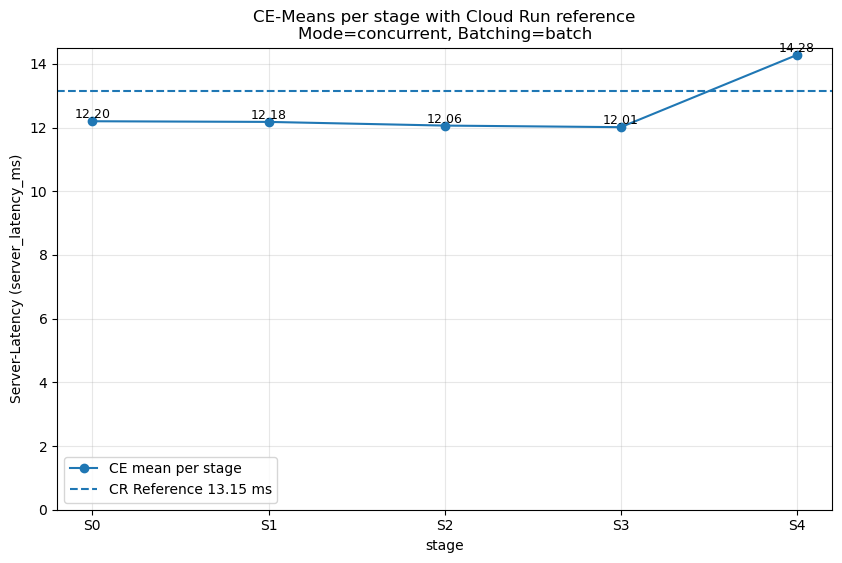

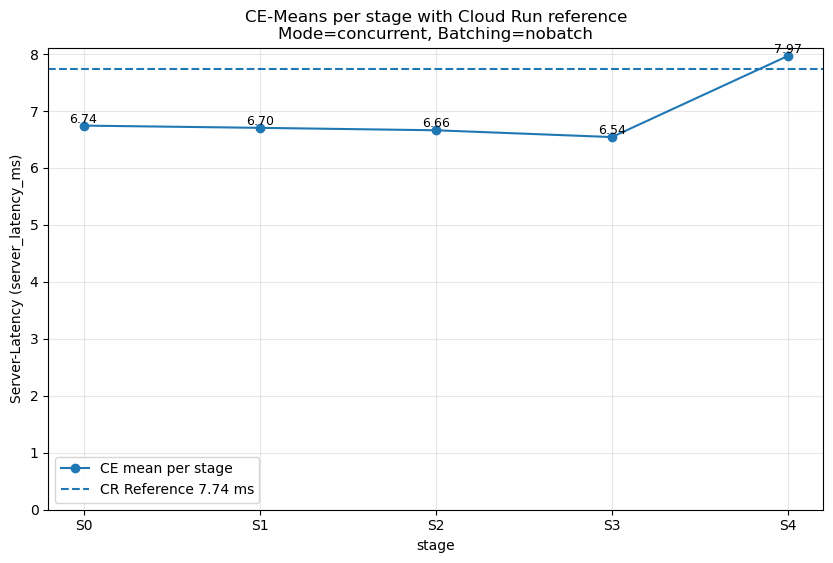

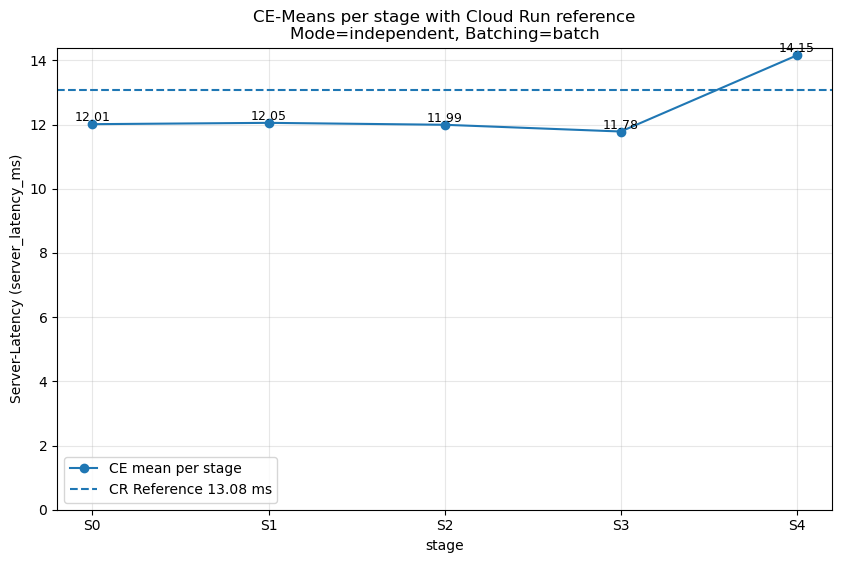

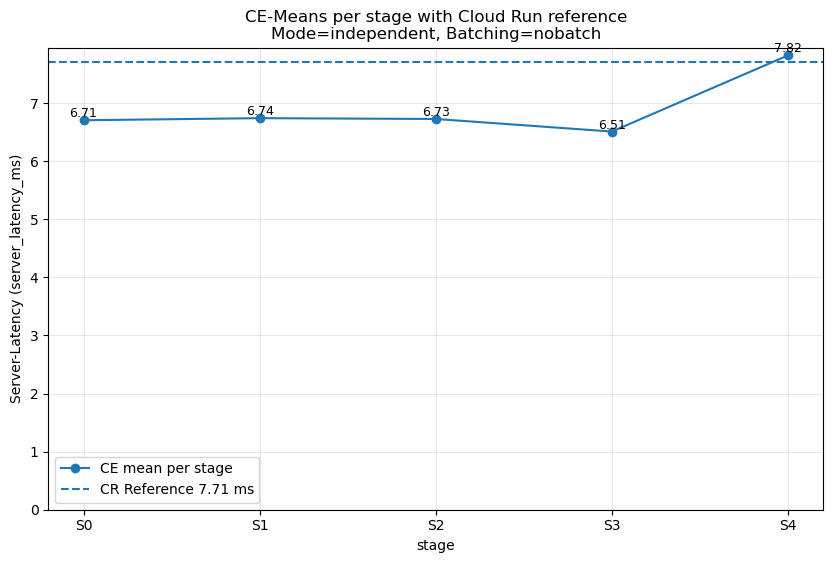

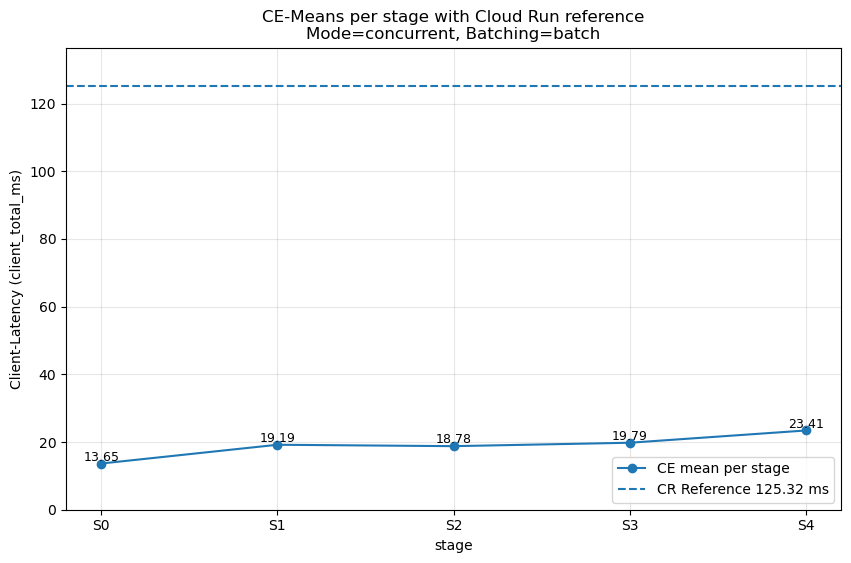

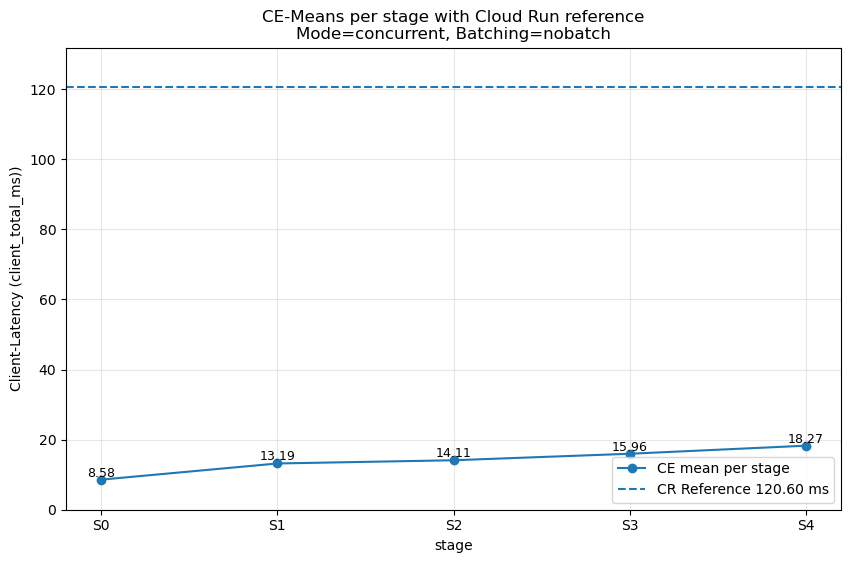

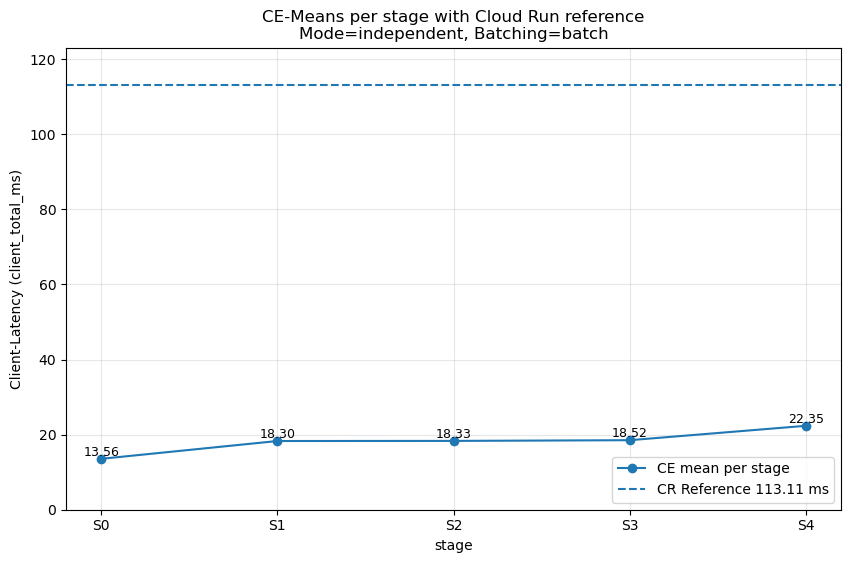

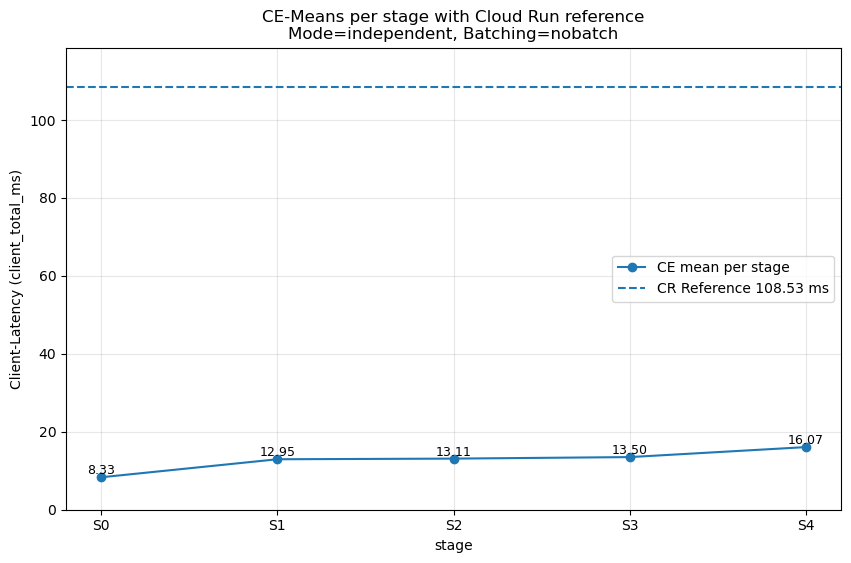

In [147]:
plot_ce_means_per_phase_with_cr_ref(
    ce_phase_metrics_server,
    cr_ref_server,   # sind server Referenzen
    mode="concurrent",
    batching="batch",
    metric_label="Server-Latency (server_latency_ms)",
)
plot_ce_means_per_phase_with_cr_ref(
    ce_phase_metrics_server,
    cr_ref_server,   # sind server Referenzen
    mode="concurrent",
    batching="nobatch",
    metric_label="Server-Latency (server_latency_ms)",
)
plot_ce_means_per_phase_with_cr_ref(
    ce_phase_metrics_server,
    cr_ref_server,   # sind server Referenzen
    mode="independent",
    batching="batch",
    metric_label="Server-Latency (server_latency_ms)",
)
plot_ce_means_per_phase_with_cr_ref(
    ce_phase_metrics_server,
    cr_ref_server,   # sind server Referenzen
    mode="independent",
    batching="nobatch",
    metric_label="Server-Latency (server_latency_ms)",
)

plot_ce_means_per_phase_with_cr_ref(
    ce_phase_metrics_client,
    cr_ref_client,   
    mode="concurrent",
    batching="batch",
    metric_label="Client-Latency (client_total_ms)",
)
plot_ce_means_per_phase_with_cr_ref(
    ce_phase_metrics_client,
    cr_ref_client,  
    mode="concurrent",
    batching="nobatch",
    metric_label="Client-Latency (client_total_ms))",
)
plot_ce_means_per_phase_with_cr_ref(
    ce_phase_metrics_client,
    cr_ref_client,   
    mode="independent",
    batching="batch",
    metric_label="Client-Latency (client_total_ms)",
)
plot_ce_means_per_phase_with_cr_ref(
    ce_phase_metrics_client,
    cr_ref_client,   
    mode="independent",
    batching="nobatch",
    metric_label="Client-Latency (client_total_ms)",
)





### Plot 3: Anteil aller Phase an S4

In [151]:
def plot_phase_part(ce_phase_metrics, metric_label="Latenz"):
    combos = []
    all_parts = []

    for entry in ce_phase_metrics:
        label = f"{entry['mode']}\n{entry['batching']}"
        combos.append(label)

        parts = entry["phase_parts"]   # muss in compute_ce_phase_metrics gesetzt sein
        if len(parts) < len(STAGES):
            parts = parts + [0.0] * (len(STAGES) - len(parts))
        all_parts.append(parts)

    all_parts = np.array(all_parts)  
    x = np.arange(len(combos))

    plt.figure(figsize=(14, 6))

    width = 0.15
    offsets = np.linspace(-0.3, 0.3, len(STAGES))

    for i, stage in enumerate(STAGES):
        yvals = all_parts[:, i] * 100  # Prozent

        # Balken
        plt.bar(
            x + offsets[i],
            yvals,
            width=width,
            label=stage,
        )

        # Labels
        for xi, yi in zip(x + offsets[i], yvals):
            if np.isnan(yi):
                continue
            # kleiner Offset in Daten-Einheiten
            dy = 2 if yi >= 0 else -2
            va = "bottom" if yi >= 0 else "top"

            plt.text(
                xi,
                yi + dy,
                f"{yi:.1f}%",   
                ha="center",
                va=va,
                fontsize=8,
            )

    plt.axhline(0, color="black", linewidth=1)
    plt.xticks(x, combos)
    plt.title(f"Stage-wise contribution to Additional Overhead (positive/negative) per Mode/Batching – {metric_label}")
    plt.ylabel("par (S4 − S0) in %")
    
    plt.legend(title="stage", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()



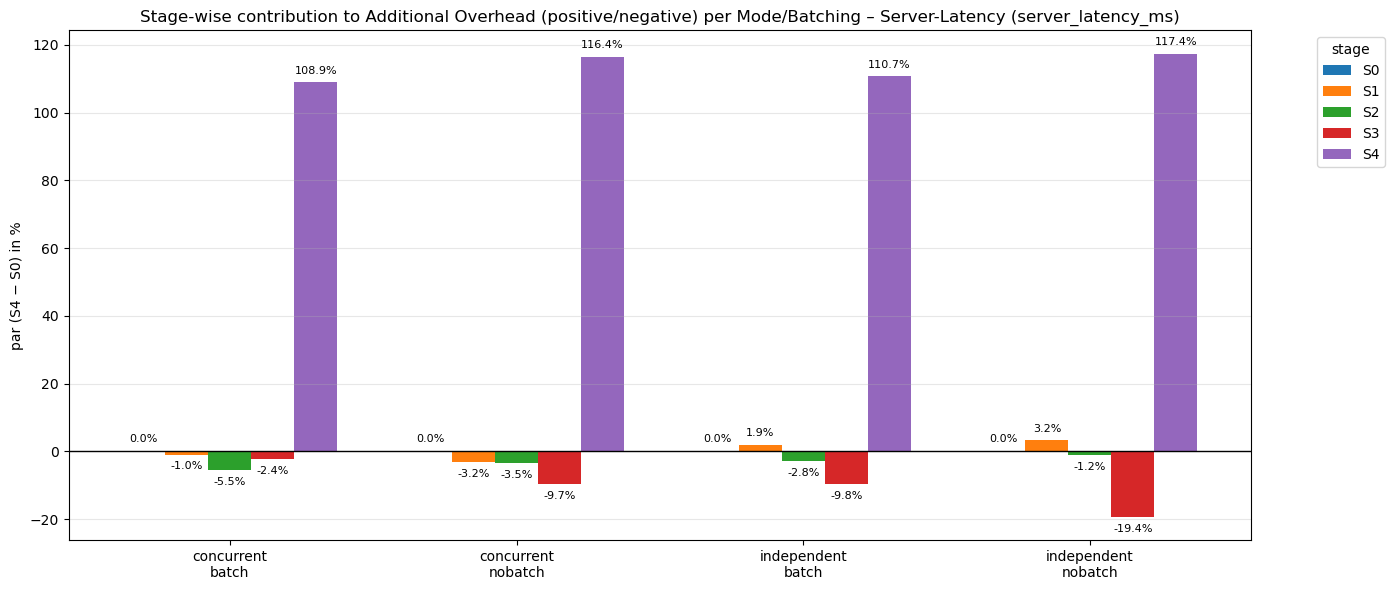

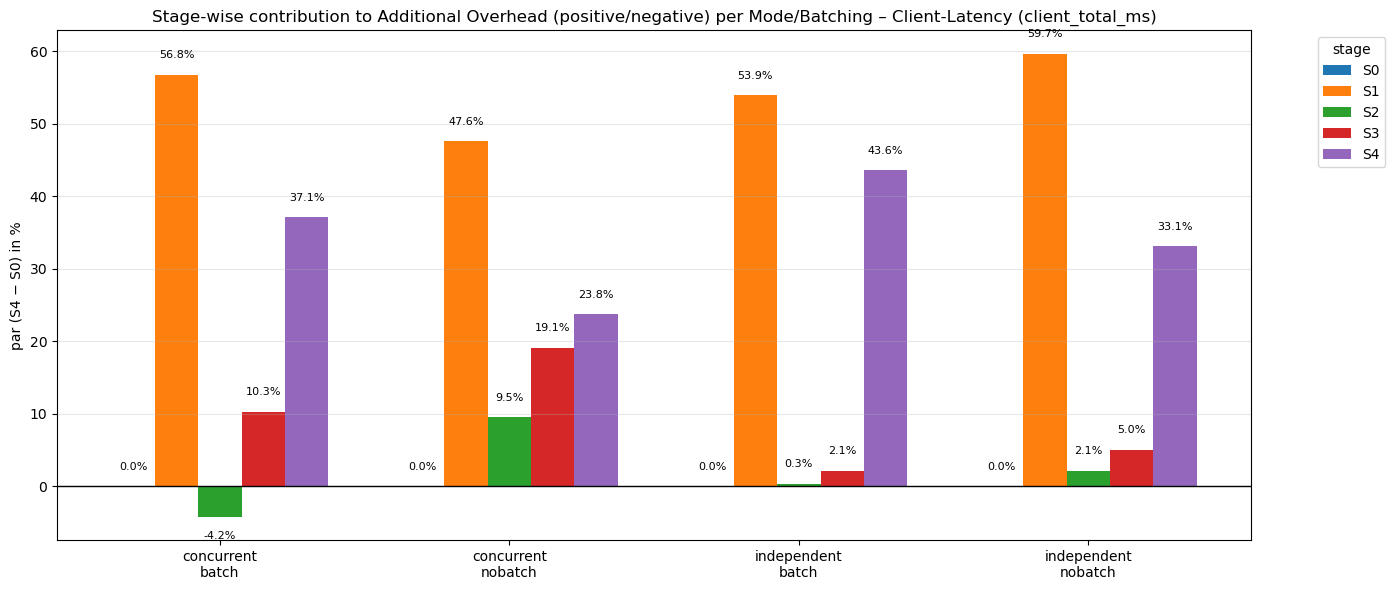

In [152]:
plot_phase_part(ce_phase_metrics_server, metric_label="Server-Latency (server_latency_ms)")

plot_phase_part(ce_phase_metrics_client, metric_label="Client-Latency (client_total_ms)")


### Plot 4  Verteilung boxplot nach Plattformen

In [ ]:
# def plot_distribution_boxplots_ce_vs_cr(lat, mode, batching, metric_col=METRIC_COL):
    
#     #CE vs CR Boxplots pro Stage nebeneinander.
#     # Zeigt Varianz/Verteilung je Plattform.
 
#     subset = lat[
#         (lat["mode"] == mode) &
#         (lat["batching"] == batching) &
#         (lat["stage"].isin(STAGES))
#     ].copy()

#     if subset.empty:
#         print(f"Keine Daten für {mode}/{batching}")
#         return

#     plt.figure(figsize=(12, 6))

#     pos = np.arange(len(STAGES)) * 2  #abstand zwischen Stages

#     width = 0.6

#     for i, stage in enumerate(STAGES):
#         stage_ce = subset[(subset["stage"] == stage) & (subset["platform"] == "ce")][metric_col]
#         stage_cr = subset[(subset["stage"] == stage) & (subset["platform"] == "cr")][metric_col]

#         if stage_ce.empty and stage_cr.empty:
#             continue

#         data = []
#         labels = []

#         if not stage_ce.empty:
#             data.append(stage_ce.values)
#             labels.append("CE")
#         if not stage_cr.empty:
#             data.append(stage_cr.values)
#             labels.append("CR")

#         #boxplots für diese Stage an leicht versetzten Positionen
#         bp = plt.boxplot(
#             data,
#             positions=[pos[i] + offset for offset in np.linspace(-0.3, 0.3, len(data))],
#             widths=width,
#             labels=labels,
#             patch_artist=True,
#         )

#     plt.xticks(pos, STAGES)
#     plt.title(f"Verteilung CE vs. CR per stage\nMode={mode}, Batching={batching}")
#     plt.ylabel(metric_col)
#     plt.grid(axis="y", alpha=0.3)
#     plt.ylim(bottom=0)
#     plt.show()


### Plot 5 heatmap 


In [ ]:
# def plot_phase_importance_heatmap(ce_phase_metrics):
   
#     # Heatmap: Zeigt pro (mode, batching) und Stage den Prozentanteil an S4.
#     # x-Achse: Stage
#     # y-Achse: Mode/Batching
#     # Zelle: % Anteil an S4

#     rows = []

#     for entry in ce_phase_metrics:
#         combo = f"{entry['mode']}/{entry['batching']}"
#         parts = entry["phase_shares"]  # in 0..1
#         for stage, share in zip(entry["stages"], shares):
#             rows.append({
#                 "combo": combo,
#                 "stage": stage,
#                 "share_percent": share * 100,
#             })

    # df = pd.DataFrame(rows)

    # if df.empty:
    #     print("Keine CE-Phasen-Metriken vorhanden.")
    #     return

    # pivot = df.pivot(index="combo", columns="stage", values="share_percent")
    # pivot = pivot.reindex(columns=STAGES)  # Stage-Reihenfolge erzwingen

    # plt.figure(figsize=(8, 6))
    # im = plt.imshow(pivot.values, aspect="auto")

    # plt.xticks(np.arange(len(STAGES)), STAGES)
    # plt.yticks(np.arange(len(pivot.index)), pivot.index)

    # plt.colorbar(im, label="% Contribution an S4")
    # plt.title("Relative Phase Importance (CE) – Contribution to S4 per Mode/Batching")
    # plt.xlabel("Stage")
    # plt.ylabel("Mode/Batching")

    # # Werte in die Zellen schreiben
    # for i in range(pivot.shape[0]):
    #     for j in range(pivot.shape[1]):
    #         val = pivot.iloc[i, j]
    #         if not np.isnan(val):
    #             plt.text(j, i, f"{val:.1f}", ha="center", va="center", color="white")

    # plt.tight_layout()
    
    # plt.show()


### Gruppierung nach Tageszeit 
--> muss dazu die drei vollständigen Tagesmessungen finden dh Messungen, wo alle 5 Phasen einmal durchgelaufen sind 

In [140]:
def find_complete_ce_days(lat):
    ce = lat[lat["platform"] == "ce"].copy()
    if "day" not in ce.columns:
        ce["day"] = ce["run"].str.extract(r"(\d{4}-\d{2}-\d{2})")

    complete_days = []

    grouped = ce.groupby("day")

    for day, df_day in grouped:
        combos = df_day.groupby(["stage", "mode", "batching"]).size().reset_index()
        ok = True
        for stage in STAGES:
            for mode in MODES:
                for batching in BATCHINGS:
                    mask = (
                        (combos["stage"] == stage) &
                        (combos["mode"] == mode) &
                        (combos["batching"] == batching)
                    )
                    if not mask.any():
                        ok = False
                        break
                if not ok:
                    break
            if not ok:
                break
        if ok:
            complete_days.append(day)

    return complete_days

## pro tag un dpro kombi (mode und batching)
def extract_ce_means_per_day_and_mode(complete_days, metric="client_total_ms"):
    
    day_mode_map = {}

    for day, info in complete_days.items():
        day_mode_map[day] = {}

        for mode in MODES:
            for batching in BATCHINGS:
                stage_values = []

                for stage in STAGES:
                    # Stage überhaupt im Day vorhanden?
                    stage_paths = info.get("paths", {}).get(stage)
                    if not stage_paths:
                        stage_values.append(np.nan)
                        continue

                    # Root für dieses mode
                    run_path = stage_paths.get(mode)
                    if run_path is None:
                        stage_values.append(np.nan)
                        continue

                    # alle csv für dieses batching 
                    pattern = f"latencies_ce_{batching}_*.csv"
                    csvs = list(run_path.glob(pattern))
                    if not csvs:
                        stage_values.append(np.nan)
                        continue

                    vals = []
                    for csv in csvs:
                        df = pd.read_csv(csv)
                        if metric in df.columns:
                            vals.append(df[metric].values)

                    if not vals:
                        stage_values.append(np.nan)
                        continue

                    all_vals = np.concatenate(vals)
                    stage_values.append(all_vals.mean())

                day_mode_map[day][(mode, batching)] = stage_values

    return day_mode_map

In [141]:
complete_days = find_complete_ce_days(lat)
print("Komplette CE-Tage:", complete_days)

Komplette CE-Tage: ['2025-11-15', '2025-11-18']


In [143]:
def plot_ce_per_day_with_modes(lat, day, metric_col="client_total_ms", metric_label=None):
    if metric_label is None:
        metric_label = metric_col

    ce = lat[lat["platform"] == "ce"].copy()
    if "day" not in ce.columns:
        ce["day"] = ce["run"].str.extract(r"(\d{4}-\d{2}-\d{2})")

    df = (
        ce[(ce["day"] == day)]
        .groupby(["stage", "mode", "batching"])[metric_col]
        .mean()
        .reset_index()
    )

    if df.empty:
        print(f"Keine CE-Daten für Tag {day}")
        return

    plt.figure(figsize=(10, 6))

    colors = {
        ("concurrent", "batch"): "tab:blue",
        ("concurrent", "nobatch"): "tab:purple",
        ("independent", "batch"): "tab:green",
        ("independent", "nobatch"): "tab:red",
    }
    x_pos = np.arange(len(STAGES))

    offsets_y = {
        ("concurrent", "batch"): 0.16,
        ("concurrent", "nobatch"): 0.01,
        ("independent", "batch"): 0.00,
        ("independent", "nobatch"): -0.15,
    }
    offsets_x = {
        ("concurrent", "batch"): 0.12,
        ("concurrent", "nobatch"): 0.1,
        ("independent", "batch"): -0.04,
        ("independent", "nobatch"): -0.08,
    }

    all_vals = []

    for mode in MODES:
        for batching in BATCHINGS:
            combo_df = df[(df["mode"] == mode) & (df["batching"] == batching)]
            if combo_df.empty:
                continue

            combo_df = combo_df.set_index("stage").reindex(STAGES)
            values = combo_df[metric_col].values
            all_vals.extend([v for v in values if not np.isnan(v)])
            line_color = colors.get((mode, batching), "black")

            plt.plot(
                x_pos, values, marker="o",
                label=f"{mode}/{batching}",
                color=line_color,
            )

            dy_base = offsets_y.get((mode, batching), 0.0)
            dx = offsets_x.get((mode, batching), 0.0)
            for xi, y in zip(x_pos, values):
                if not np.isnan(y):
                    dy = dy_base + 0.05 * abs(y)
                    plt.text(
                        xi + dx, y + dy, f"{y:.2f}",
                        ha="center", va="bottom",
                        fontsize=8, color=line_color,
                        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1.5),
                    )

    plt.xticks(x_pos, STAGES)
    plt.title(f"CE daily Latency Profile (CE): {day} – {metric_label}")
    plt.xlabel("Stage")
    plt.ylabel(metric_label)
    plt.legend()
    plt.grid(True, alpha=0.3)

    if all_vals:
        y_min, y_max = min(all_vals), max(all_vals)
        span = y_max - y_min if y_max > y_min else y_max
        pad = 0.15 * span if span else 0.5
        plt.ylim(bottom=max(0, y_min - pad * 0.2), top=y_max + pad)
    else:
        plt.ylim(bottom=0)

    plt.tight_layout()
    plt.show()



   

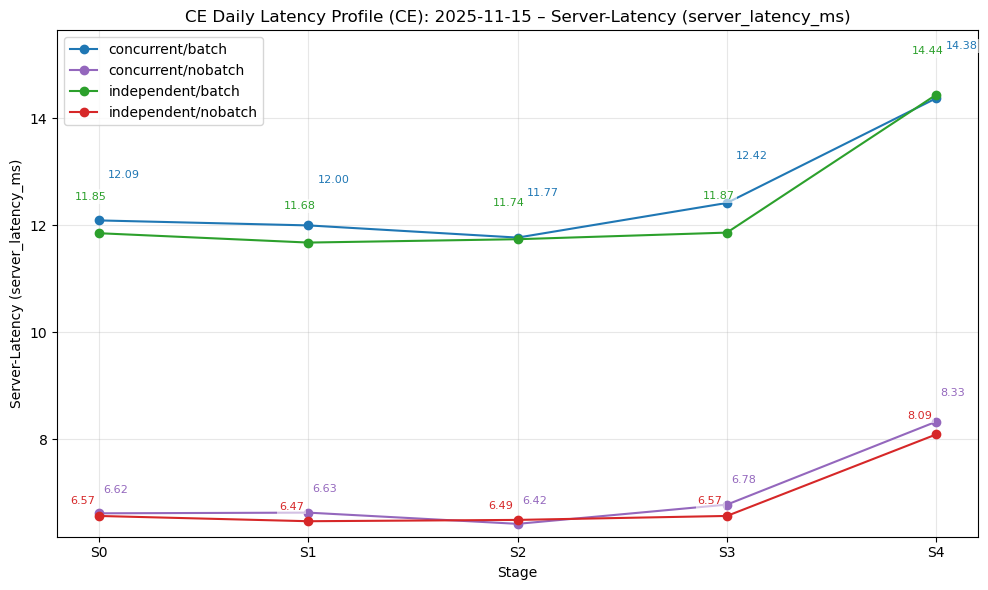

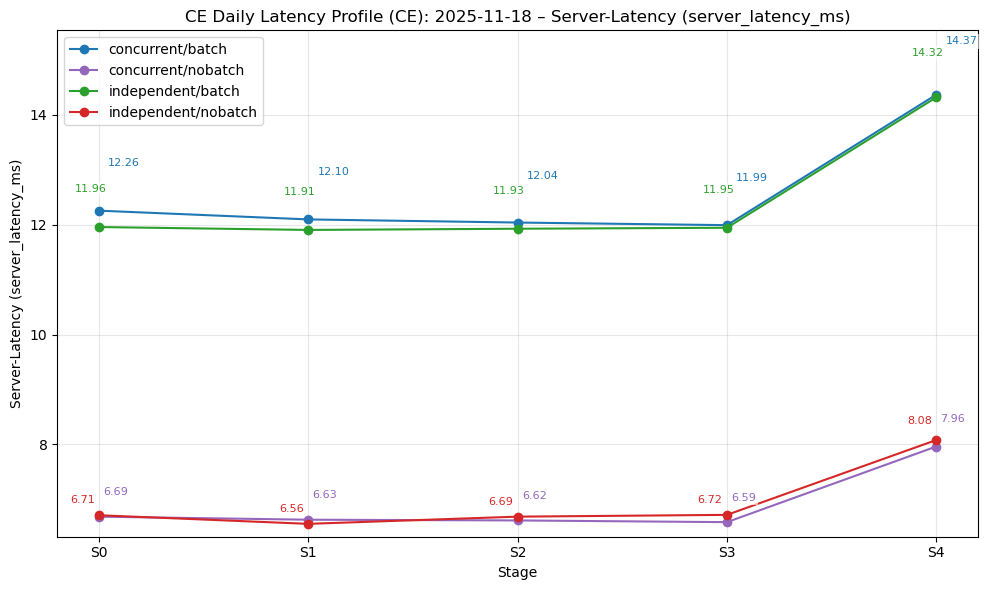

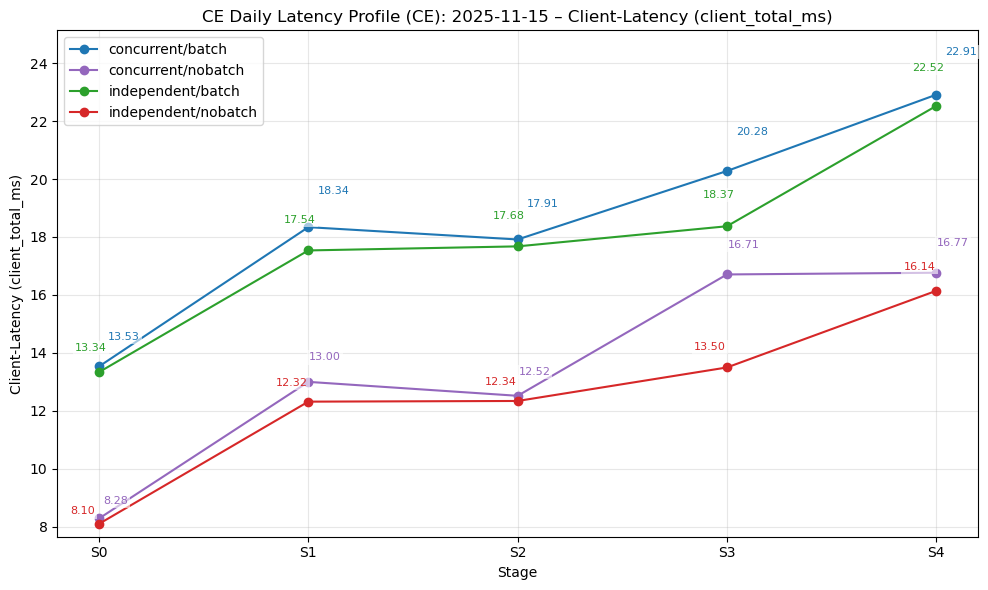

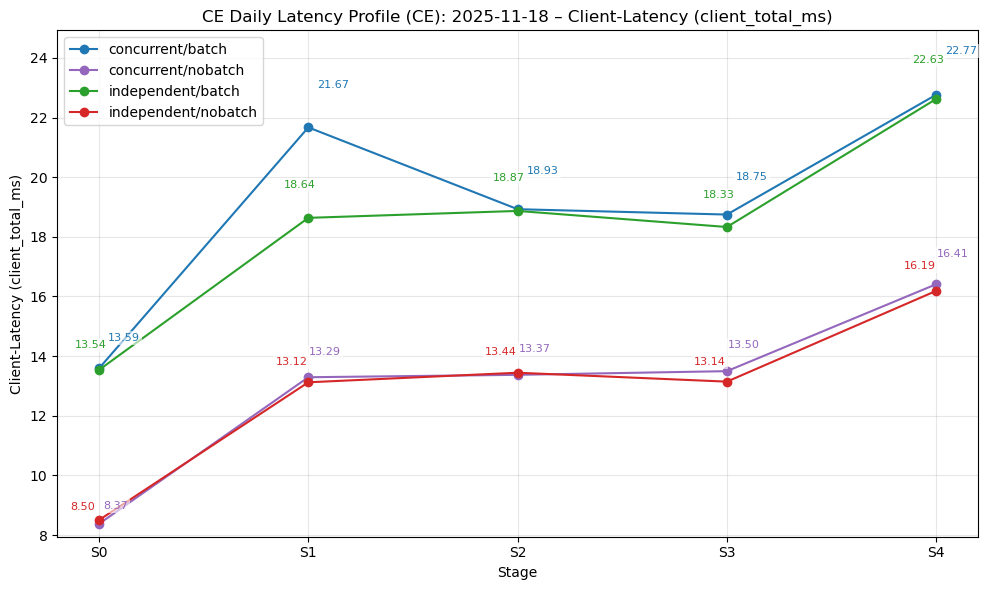

In [142]:

for day in complete_days:
    plot_ce_per_day_with_modes(lat, day, metric_col="server_latency_ms", metric_label="Server-Latency (server_latency_ms)")


for day in complete_days:
    plot_ce_per_day_with_modes(lat, day, metric_col="client_total_ms", metric_label="Client-Latency (client_total_ms)")

# y achse inklusive 0 